<a href="https://colab.research.google.com/github/votamvan/cs582/blob/master/project1_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/votamvan/cs582.git

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.svm import SVC

train_path = "/content/cs582/data/house-prices/train.csv"
train_df = pd.read_csv(train_path)
train_df = train_df[train_df['GarageArea'] < 1200]
train_df['enc_street'] = pd.get_dummies(train_df.Street, drop_first=True)
train_df['enc_condition'] = train_df.SaleCondition.apply(lambda x: 1 if x == 'Partial' else 0)
data = train_df.select_dtypes(include=[np.number]).interpolate().dropna()
X = data.drop(['SalePrice', 'Id'], axis=1)
y = np.log(train_df.SalePrice)
mean_y = np.mean(y)
y[y <= mean_y] = 0
y[y > mean_y] = 1
y = y.astype(int)
print(f"Finish load data, total = {y.shape[0]}")

Finish load data, total = 1455


In [0]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn import preprocessing

# Standardization of datasets
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
tuned_parameters = {
    'C': [0.001, 0.1, 1, 10, 100]
}
grid = GridSearchCV(LinearSVC(), tuned_parameters, cv=5, n_jobs=-1)
grid.fit(X, y)
estimator = grid.best_estimator_
print(f'Best score: {grid.best_score_}')
print(grid.best_estimator_)

Best score: 0.9250859106529209
LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


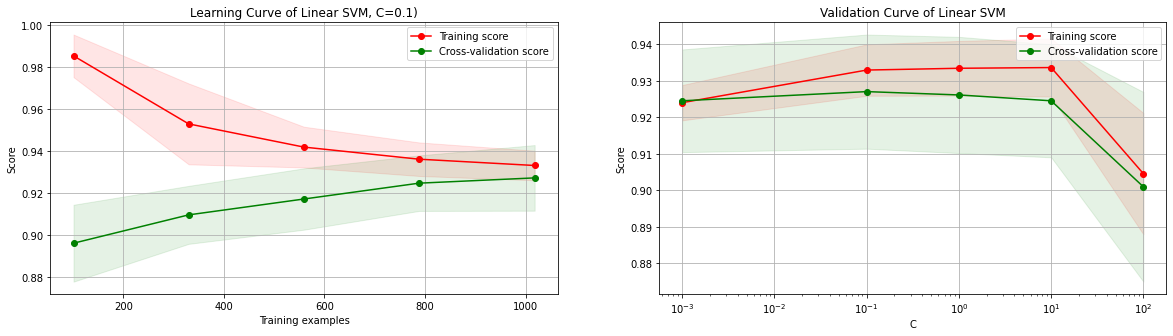

In [0]:
def plot_learning_curve(estimator, title, X, y, ax=None, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if ax is None: _, ax = plt.subplots(figsize=(20, 5))
    ax.set_title(title)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    # Plot learning curve
    ax.grid()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    ax.legend(loc="best")
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    return plt

def plot_validation_curve(estimator, title, X, y, ax=None, cv=None, param_name=None, param_range=None):
    if ax is None: _, ax = plt.subplots(figsize=(20, 5))
    ax.set_title(title)
    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, 
                                                 param_range=param_range, scoring="accuracy", cv=cv, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    # Plot learning curve
    ax.grid()
    ax.semilogx(param_range, train_scores_mean, 'o-', color="r", label="Training score")
    ax.fill_between(param_range, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.semilogx(param_range, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    ax.fill_between(param_range, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.legend(loc="best")
    ax.set_xlabel(r"C")
    ax.set_ylabel("Score")
    return plt

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
title = f"Learning Curve of Linear SVM, C={estimator.C})"
plot_learning_curve(estimator, title, X, y, ax=ax1, cv=cv)
plot_validation_curve(estimator, "Validation Curve of Linear SVM", X, y, ax=ax2, cv=cv, 
                      param_name="C", param_range=[0.001, 0.1, 1, 10, 100])
plt.show()

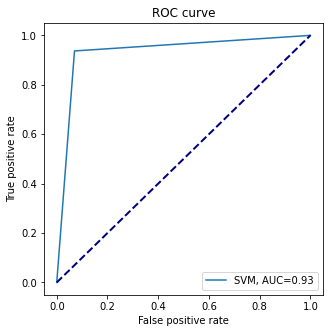

In [0]:
def plot_roc_curve(estimator, title, X, y, ax=None):
    if ax is None: _, ax = plt.subplots(figsize=(5, 5))
    y_pred = estimator.predict(X)
    fpr, tpr, _ = roc_curve(y, y_pred)
    ax.plot(fpr, tpr, label=f"{title}, AUC=" + "{:.2f}".format(metrics.auc(fpr, tpr)))
    ax.set_title('ROC curve')
    ax.legend(loc='best')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate') 
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    return plt

plot_roc_curve(estimator, "SVM", X, y)
plt.show()